In [14]:
import lightkurve as lk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_lightcurve(star):
    """
    star = the name of the star to get the lightcurve for
    returns the flattened and stiched lightcurve for use
    """
    search_result = lk.search_lightcurve(star, author='Kepler', cadence='long')
    lc_collection = search_result.download_all()
    return lc_collection.stitch().flatten(window_length=901).remove_outliers()

In [ ]:
R_SUN = 6.957e8 #radius of the sun in meters
AU_TO_METERS = 1.496e11 #How many meters in an AU
def T_planet(lc, a, albedo=0.5):
    """
    lc = the downloaded light curve from the search result
    a = semimajor axis length (in terms of meters)
    albedo = ratio of reflected light to incoming light
    returns the temperature of the planet in Kelvin
    """
    T,R = lc.meta["TEFF"],lc.meta["RADIUS"]*R_SUN #Convert from solar radius to meters since meta is in solar radius
    return T*np.pow((R**2)*(1-albedo)/(4*a**2),1/4) #Radiative Equilibrium Temperature (assuming BlackBody radiation going in and out is the same)

In [22]:
def R_planet(lc,t,albedo = 0.5):
    """
    lc = the downloaded light curve from the search result
    t = target temperature of planet (Kelvin)
    albedo = ratio of reflected light to incoming light
    returns the semimajor axis length of a planet with that temperature (neglecting greenhouse and geothermal effects)
    """
    T,R = lc.meta["TEFF"],lc.meta["RADIUS"]*R_SUN
    return (T**2/t**2)*R/2*np.sqrt(1-albedo)

In [ ]:
df = pd.read_csv("Kepler_Stars.csv") #Reading the semimajor axis data that the other sections generated

In [23]:
albedos = np.linspace(0,0.9,10) #Albedos from 0-0.9 (Albedo of 1 is excluded because that means the planet would reflect all light, making its temperature 0 Kelvin)
lightcurves = [get_lightcurve(star) for star in df["Star"]]
temperatures = np.array([ T_planet(lc,a*AU_TO_METERS,albedos) for lc,a in zip(lightcurves,df["Planet_Semi_Major_Axis(AU)"]) ])
max_radius = np.array([ R_planet(lc,273.15,albedos) for lc in lightcurves ]) #Farthest distance from the star the planet can be with liquid water (meters)
min_radius = np.array([ R_planet(lc,373.15,albedos) for lc in lightcurves ]) #Closest distance from the star the planet can be with liquid water (in meters)

In [21]:
temperature_df = pd.DataFrame(data=temperatures,columns=["Albedo = " + str(a) for a in albedos])
temperature_df.insert(0,"Star",df["Star"])
temperature_df.to_csv("Temperatures.csv")

array([[2.38856845e+11, 3.22058769e+11, 1.91458234e+11, 3.32269887e+11,
        1.39700307e+11, 4.61977356e+11, 1.54720019e+11],
       [2.26599500e+11, 3.05531775e+11, 1.81633229e+11, 3.15218892e+11,
        1.32531348e+11, 4.38270201e+11, 1.46780298e+11],
       [2.13640057e+11, 2.88058120e+11, 1.71245450e+11, 2.97191222e+11,
        1.24951753e+11, 4.13205109e+11, 1.38385792e+11],
       [1.99841974e+11, 2.69453698e+11, 1.60185451e+11, 2.77996933e+11,
        1.16881663e+11, 3.86517987e+11, 1.29448056e+11],
       [1.85017717e+11, 2.49465650e+11, 1.48302910e+11, 2.57375148e+11,
        1.08211392e+11, 3.57846121e+11, 1.19845612e+11],
       [1.68897295e+11, 2.27729939e+11, 1.35381415e+11, 2.34950290e+11,
        9.87830344e+10, 3.26667321e+11, 1.09403575e+11],
       [1.51066333e+11, 2.03687850e+11, 1.21088819e+11, 2.10145928e+11,
        8.83542320e+10, 2.92180134e+11, 9.78535322e+10],
       [1.30827282e+11, 1.76398852e+11, 1.04865993e+11, 1.81991712e+11,
        7.65170094e+10, 2

In [ ]:
radius_df = pd.DataFrame(data = (max_radius.T.append(min_radius.T)).T)

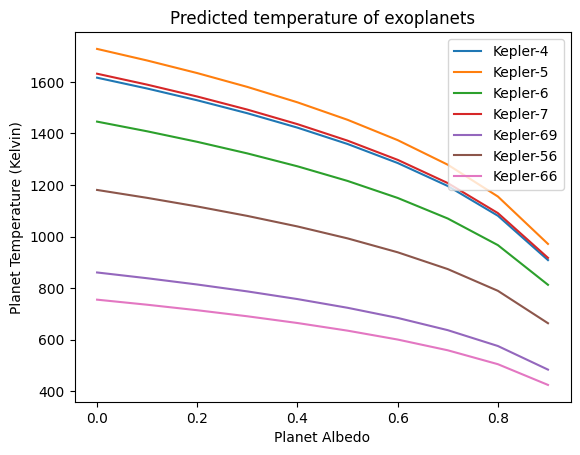

In [45]:
#Plotting the temperatures of the exoplanets
fig,ax = plt.subplots()
[ax.plot(albedos,t,label=star) for t,star in zip(temperatures,df["Star"])]
ax.legend()
ax.set_xlabel("Planet Albedo")
ax.set_ylabel("Planet Temperature (Kelvin)")
ax.set_title("Predicted temperature of exoplanets")
fig.savefig("TemperaturePlot.png")

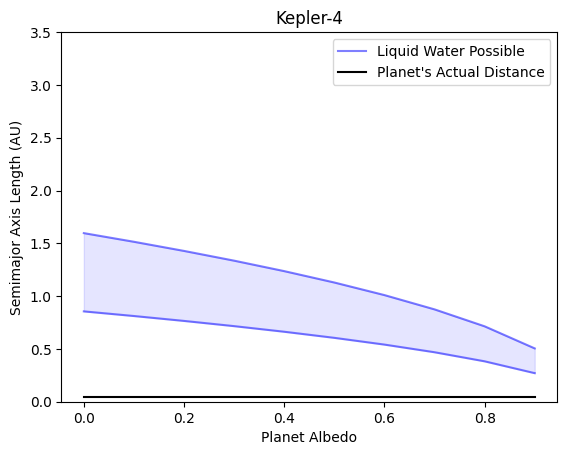

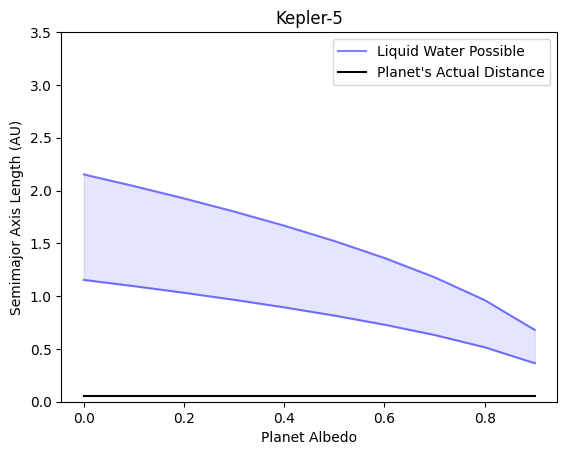

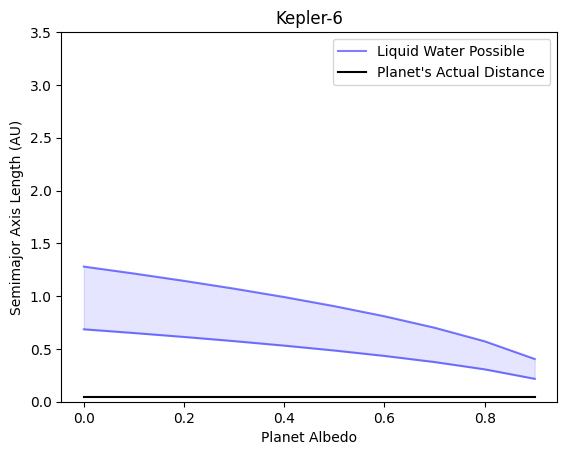

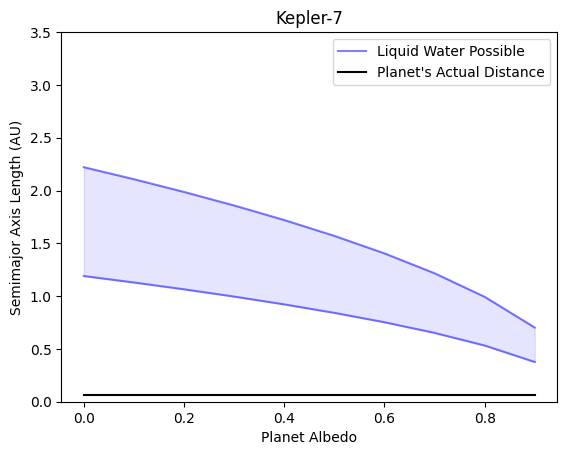

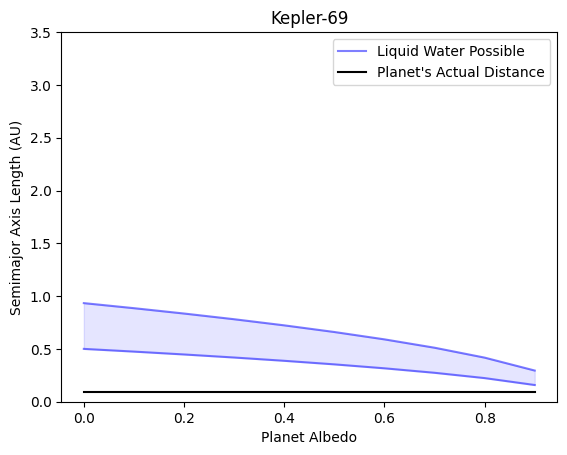

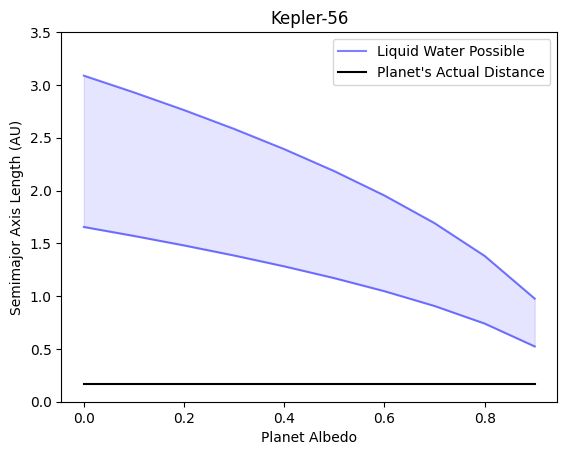

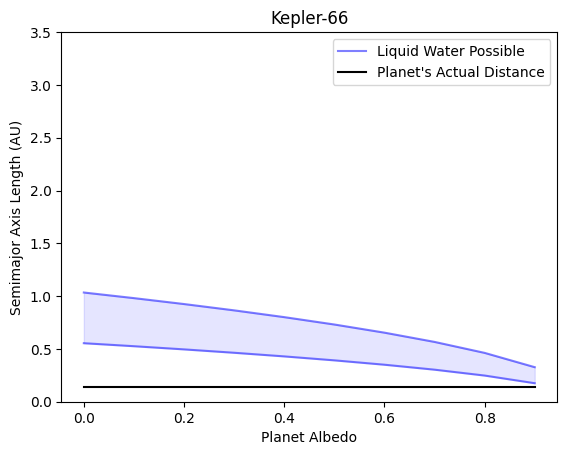

In [46]:
for r,R,star,a in zip(min_radius/AU_TO_METERS,max_radius/AU_TO_METERS,df["Star"],df["Planet_Semi_Major_Axis(AU)"]):
    fig,ax = plt.subplots()
    ax.fill_between(albedos,r,R,alpha=0.1,color='blue'),
    ax.plot(albedos,r,alpha=0.5,color='blue',label="Liquid Water Possible"),
    ax.plot(albedos,R,alpha=0.5,color='blue')
    ax.plot(albedos,np.ones(len(albedos))*a,label = "Planet's Actual Distance",color='k')
    ax.set_ylim(0,3.5)
    ax.set_xlabel("Planet Albedo")
    ax.set_ylabel("Semimajor Axis Length (AU)")
    ax.set_title(star)
    ax.legend()
    fig.savefig(star + "HabitableZone.png")
# colors = ['k',"red","orange","olive","green","cyan","blue","pink","purple"]
# [(ax2.fill_between(albedos,r,R,label=star,alpha=0.1,color=c),
#   ax2.plot(albedos,r,alpha=0.5,color=c),
#   ax2.plot(albedos,R,alpha=0.5,color=c)
#   ) for r,R,star,c in zip(min_radius/AU_TO_METERS,max_radius/AU_TO_METERS,df["Star"],colors)]